In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


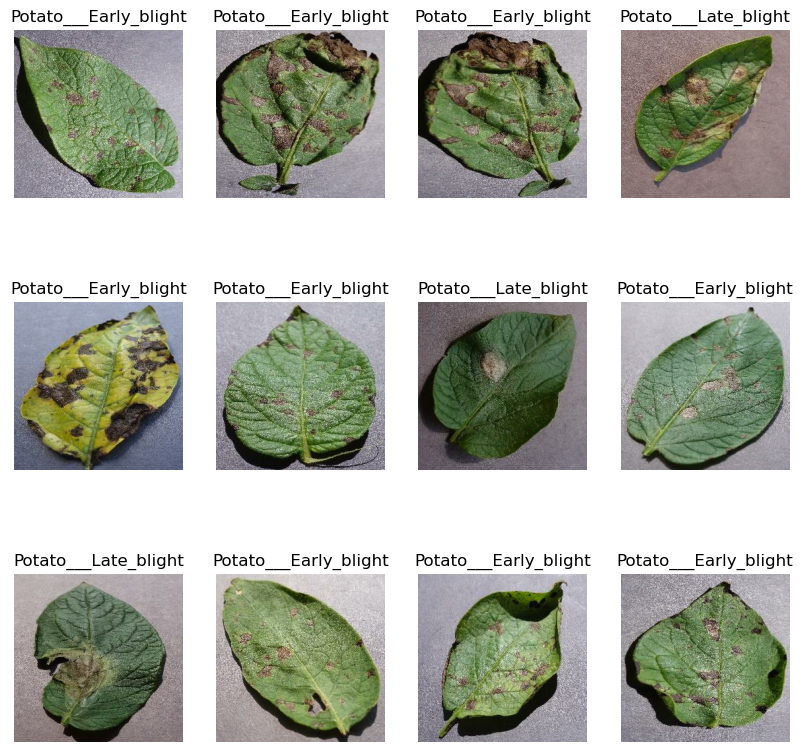

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1.0 / 255)
])


In [21]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])


In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Remove BATCH_SIZE here
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),  # Use Input() as the first layer
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.4593 - loss: 0.9401 - val_accuracy: 0.6042 - val_loss: 0.8104
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6870 - loss: 0.7416 - val_accuracy: 0.6771 - val_loss: 0.8578
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7785 - loss: 0.5024 - val_accuracy: 0.8125 - val_loss: 0.3939
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8526 - loss: 0.3610 - val_accuracy: 0.7760 - val_loss: 0.4587
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8789 - loss: 0.3050 - val_accuracy: 0.8229 - val_loss: 0.3677
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8853 - loss: 0.2808 - val_accuracy: 0.8802 - val_loss: 0.3345
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8977 - loss: 0.2741 - val_accuracy: 0.9167 - val_loss: 0.2316
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9111 - loss: 0.2137 - val_accuracy: 0.9062 - val_loss:

In [27]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - accuracy: 0.9835 - loss: 0.0874


In [28]:
scores

[0.11208106577396393, 0.96875]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

15

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9026934504508972,
 0.6600852012634277,
 0.46385887265205383,
 0.3804841935634613,
 0.2995489537715912]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

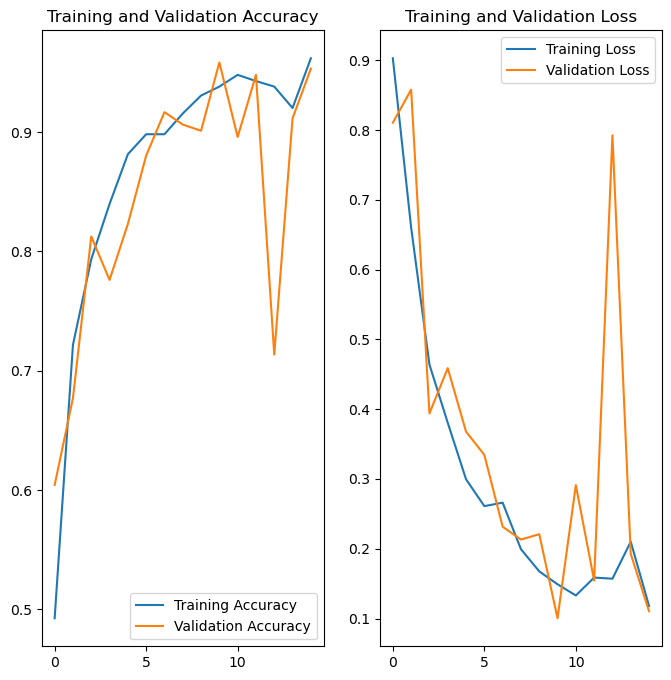

In [36]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
predicted label: Potato___Late_blight


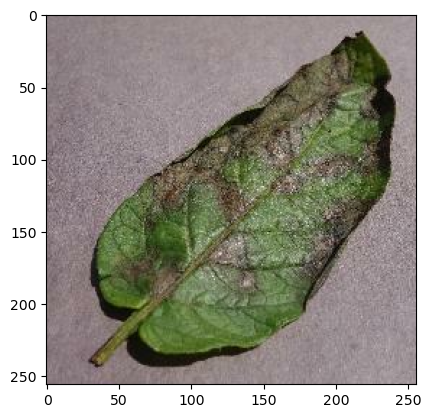

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


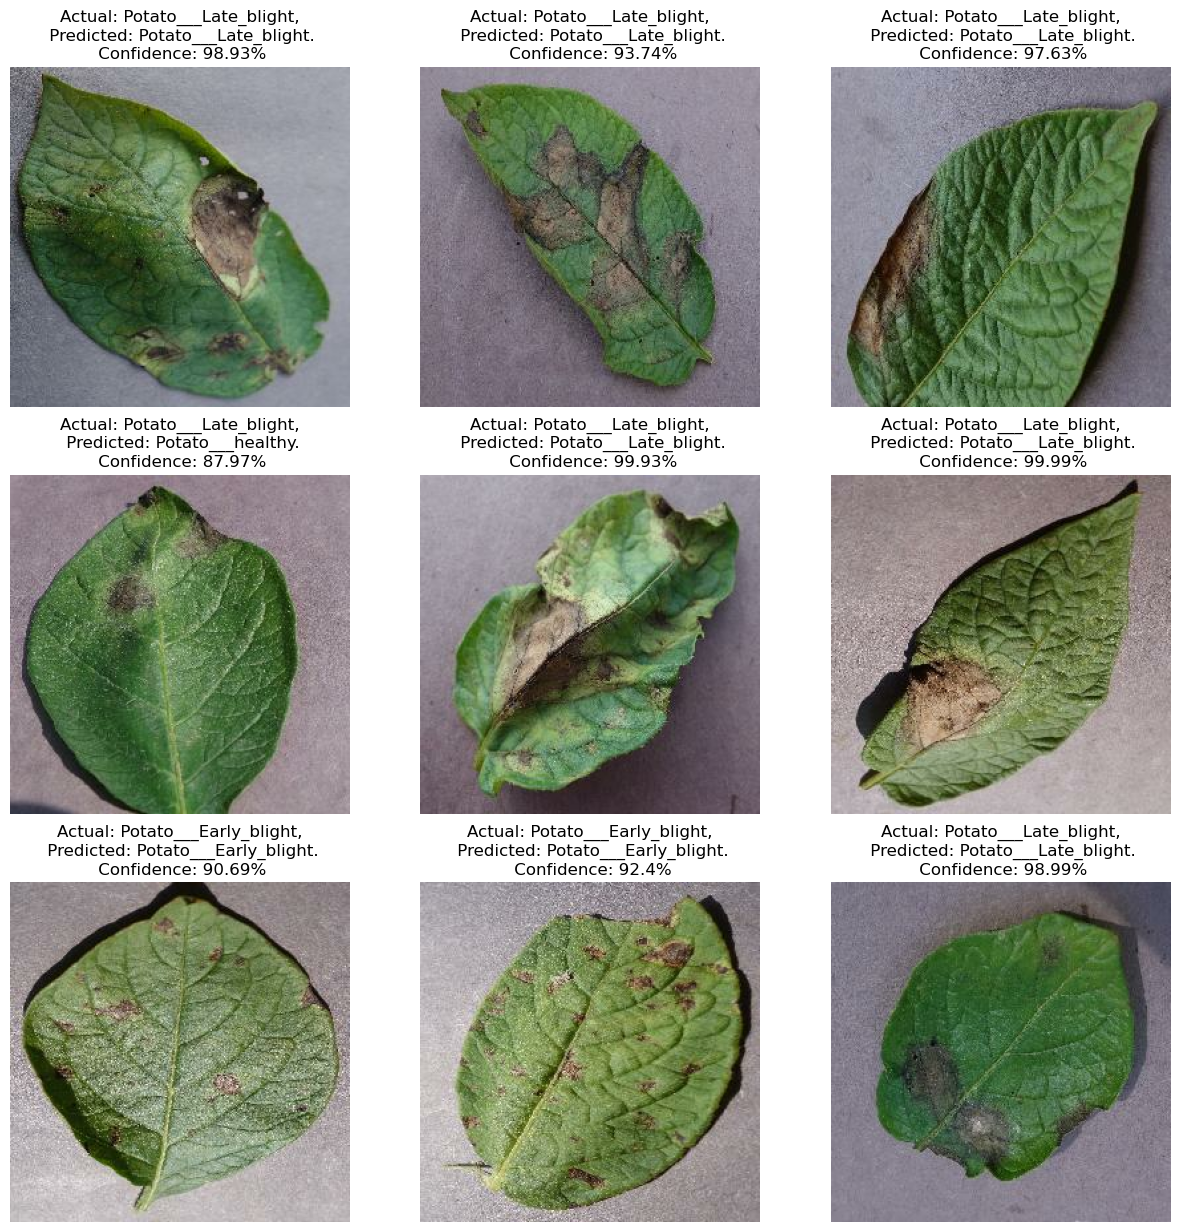

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

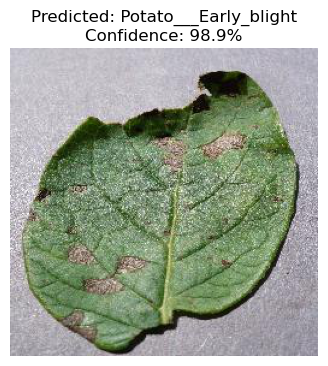

In [ ]:
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import threading

# Prediction function
def predict(model, image):
    img_array = np.expand_dims(image, axis=0)  # Add batch dimension
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100
    return predicted_class, round(confidence, 2)

# Read and process image
def read_and_process_image(file_path):
    image = Image.open(file_path)
    image = image.resize((256, 256))  # Resize to match the model's expected input size
    img_array = np.array(image)
    return image, img_array

# Handle image upload and prediction
def upload_and_predict():
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.png;*.jpeg")])
    if not file_path:
        return
    
    def process_image():
        try:
            # Read and process image
            image, img_array = read_and_process_image(file_path)
            
            # Make prediction
            predicted_class, confidence = predict(model, img_array)
            
            # Display results
            display_results(image, predicted_class, confidence, img_array)
        except Exception as e:
            result_label.config(text=f"Error: {str(e)}", fg="red")

    # Run in a separate thread to avoid UI freezing
    threading.Thread(target=process_image).start()

# Display prediction results
def display_results(image, predicted_class, confidence, img_array):
    # Display image below the button
    img_tk = ImageTk.PhotoImage(image)
    img_label.config(image=img_tk)
    img_label.image = img_tk
    img_label.place(relx=0.5, rely=0.35, anchor="center")  # Moved image down

    # Show prediction result below image
    result_label.config(
        text=f"🌱 Predicted: {predicted_class}\n🎯 Confidence: {confidence}%",
        fg="white",
        bg="#4CAF50",
    )
    result_label.place(relx=0.5, rely=0.65, anchor="center")  # Moved result down

    # Plot results in Jupyter
    plt.figure(figsize=(4, 4))
    plt.imshow(img_array.astype("uint8"))
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()

# Create Tkinter GUI
root = tk.Tk()
root.title("AgriVision 🌾")
root.geometry(f"{root.winfo_screenwidth()}x{root.winfo_screenheight()}+0+0")
root.configure(bg="#f0f8ea")

# Frame for main content
main_frame = tk.Frame(root, bg="#f0f8ea")
main_frame.pack(expand=True, fill="both")

# Header with App Title
title_label = Label(
    main_frame,
    text="🌿 AgriVision - Potato leaf Disease Detection 🌿",
    font=("Helvetica", 28, "bold"),
    bg="#4CAF50",
    fg="white",
    pady=10,
)
title_label.pack(side="top", fill="x")

# Upload button
upload_button = Button(
    main_frame,
    text="📸 Upload Image",
    command=upload_and_predict,
    bg="#4CAF50",
    fg="white",
    font=("Helvetica", 14, "bold"),
    padx=20,
    pady=10,
    relief="raised",
    bd=4,
)
upload_button.place(relx=0.5, rely=0.15, anchor="center")

# Image display area (placed lower)
img_label = Label(main_frame, bg="#f0f8ea")
img_label.place(relx=0.5, rely=0.35, anchor="center")

# Prediction result label (moved down)
result_label = Label(
    main_frame,
    text="",
    font=("Helvetica", 16, "bold"),
    bg="#f0f8ea",
)
result_label.place(relx=0.5, rely=0.65, anchor="center")

# Run Tkinter GUI
def start_gui():
    root.mainloop()

# Start GUI
start_gui()